# Demand Models

We consider three approaches to model demand (board and alight counts):

1. Random Forest-Random Forest: We train a random forest model to classify zero counts, and we also train a second random forest model for counts.
2. Classification: Instead of modeling demand as a regression problem, we build three different labels to indicate low, average, and high demand. Then, we train tree-based methods to model (classify) these labels.
3. Neural Networks and Zero Inflated models.

In [1]:
import numpy as np
import pandas as pd
import timeit
import pickle
import os
import timeit
import dask.dataframe as dd

In [2]:
carta = pd.read_csv('data/jmartinez/Transit_Data/carta.csv', low_memory = False)

In [3]:
carta.stop_id = carta['stop_id'].astype(str)
carta.trip_id = carta['trip_id'].astype(str)
carta.hour = carta['hour'].astype(str)
carta.stop_sequence = carta['stop_sequence'].astype(int)
carta.route_id = carta['route_id'].astype(str)
carta.direction_id = carta['direction_id'].astype(str)
carta.service_period = carta['service_period'].astype(str)
carta.actual_arrival_time = pd.to_datetime(carta['actual_arrival_time'], format = "%Y-%m-%d %H:%M:%S")

In [4]:
carta.actual_arrival_time = pd.to_datetime(carta['actual_arrival_time'], format = "%Y-%m-%d %H:%M:%S")

In [5]:
carta.scheduled_arrival_time = pd.to_datetime(carta['scheduled_arrival_time'], format = "%Y-%m-%d %H:%M:%S")

In [6]:
carta.date = pd.to_datetime(carta['date'], format = "%Y-%m-%d")

In [7]:
carta['year'] = carta['date'].dt.year
carta['month'] = carta['date'].dt.month

In [8]:
carta = carta.sort_values(by = 'date')

In [9]:
carta.groupby(['date'])['occupancy'].agg({max}).describe()

,max
count,478.000000
mean,27.514644
std,6.027783
min,1.000000
25%,24.000000
50%,28.000000
75%,31.000000
max,49.000000


In [10]:
carta.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,Estimated_Temp,Estimated_Precip,service_kind
0,132994,1900-01-01 04:55:00,1900-01-01 04:52:00,1351,1,35.052658,-85.309722,1,0,1,...,2019-01-02 04:52:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.35,0.000000,weekday
1193477,134417,1900-01-01 20:35:04,1900-01-01 20:37:00,971,47,35.024347,-85.246812,4,1,0,...,2019-01-02 20:37:00,1900-01-01 20:02:53,2,2019-01-02,20,2019,1,10.00,0.590889,weekday
1193478,134417,1900-01-01 20:35:30,1900-01-01 20:38:00,972,48,35.025717,-85.248528,4,1,0,...,2019-01-02 20:38:00,1900-01-01 20:02:53,2,2019-01-02,20,2019,1,10.00,0.585833,weekday
1193479,134409,1900-01-01 20:35:32,1900-01-01 20:38:00,12,87,35.050703,-85.309532,4,1,0,...,2019-01-02 20:38:00,1900-01-01 19:40:00,2,2019-01-02,20,2019,1,10.00,0.585444,weekday
1193480,134329,1900-01-01 20:35:44,1900-01-01 20:43:00,806,10,35.042653,-85.306685,4,0,0,...,2019-01-02 20:43:00,1900-01-01 20:30:00,2,2019-01-02,20,2019,1,10.00,0.583111,weekday


In [11]:
carta.shape

(9705963, 26)

In [12]:
carta.dtypes

trip_id                            object
scheduled_arrival_time     datetime64[ns]
actual_arrival_time        datetime64[ns]
stop_id                            object
stop_sequence                       int64
stop_lat                          float64
stop_lon                          float64
route_id                           object
direction_id                       object
board_count                         int64
alight_count                        int64
occupancy                           int64
direction_desc                     object
service_period                     object
date                       datetime64[ns]
scheduled_datetime                 object
actual_arrival_datetime            object
trip_start_time                    object
day_of_week                         int64
trip_date                          object
hour                               object
year                                int64
month                               int64
Estimated_Temp                    

In [12]:
min(carta.scheduled_datetime)

'2019-01-02 04:21:00'

In [13]:
max(carta.scheduled_datetime)

'2020-05-31 21:10:00'

In [14]:
carta.groupby(['route_id', 'direction_id'])['date'].agg(['min', 'max'])

min        max
route_id direction_id                      
1        0            2019-01-02 2020-05-31
         1            2019-01-02 2020-05-31
10A      0            2019-01-02 2020-05-31
         1            2019-01-02 2020-05-31
10C      0            2019-01-02 2020-04-10
10G      0            2019-01-02 2020-05-31
         1            2019-01-02 2020-05-31
13       0            2019-01-02 2020-04-09
         1            2019-01-02 2020-04-09
15       0            2019-01-02 2020-04-14
         1            2019-01-02 2020-04-10
16       0            2019-01-02 2020-05-31
         1            2019-01-02 2020-05-31
19       0            2019-01-02 2020-04-10
         1            2019-01-02 2020-04-10
2        0            2019-01-02 2020-04-10
         1            2019-01-02 2020-04-10
21       0            2019-01-02 2020-05-31
         1            2019-01-02 2020-05-31
28       0            2019-01-02 2020-04-10
         1            2019-01-02 2020-04-10
3        0            2019-01-02 2020-05-25
         1            2019-01-02 2020-05-29
4        0            2019-01-02 2020-05-31
         1            2019-01-02 2020-05-31
7        0            2019-01-02 2020-04-10
         1            2019-01-02 2020-04-10
8        0            2019-01-02 2020-04-10
         1            2019-01-02 2020-04-10
9        0            2019-01-02 2020-05-31
         1            2019-01-02 2020-05-31

## Data partition according to lock-down and ridership decline

Chattanooga's steep decline started the week of **March 5th** before hitting a low also on the week of April 19 with a low of 8,077 weekly riders.

 - Pre-lockdown data: Before 2020-03-05.
     * `date < 2020-03-05`
 - Post-lockdown data: After 2020-03-05.
     * `date >= 2020-03-05`

In [13]:
Pre_lock = carta[carta['date'] < '2020-03-05']
Post_lock = carta[carta['date'] >= '2020-03-05']

### Pre-lockdown data:

In [14]:
Pre_lock.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,Estimated_Temp,Estimated_Precip,service_kind
0,132994,1900-01-01 04:55:00,1900-01-01 04:52:00,1351,1,35.052658,-85.309722,1,0,1,...,2019-01-02 04:52:00,1900-01-01 04:55:00,2,2019-01-02,4,2019,1,8.35,0.000000,weekday
1193477,134417,1900-01-01 20:35:04,1900-01-01 20:37:00,971,47,35.024347,-85.246812,4,1,0,...,2019-01-02 20:37:00,1900-01-01 20:02:53,2,2019-01-02,20,2019,1,10.00,0.590889,weekday
1193478,134417,1900-01-01 20:35:30,1900-01-01 20:38:00,972,48,35.025717,-85.248528,4,1,0,...,2019-01-02 20:38:00,1900-01-01 20:02:53,2,2019-01-02,20,2019,1,10.00,0.585833,weekday
1193479,134409,1900-01-01 20:35:32,1900-01-01 20:38:00,12,87,35.050703,-85.309532,4,1,0,...,2019-01-02 20:38:00,1900-01-01 19:40:00,2,2019-01-02,20,2019,1,10.00,0.585444,weekday
1193480,134329,1900-01-01 20:35:44,1900-01-01 20:43:00,806,10,35.042653,-85.306685,4,0,0,...,2019-01-02 20:43:00,1900-01-01 20:30:00,2,2019-01-02,20,2019,1,10.00,0.583111,weekday


In [15]:
Pre_lock.shape

(8602818, 26)

In [16]:
r4_dir0_st12_dt = Pre_lock[(Pre_lock['route_id'] == '4') & (Pre_lock['direction_id'] == '0') & (Pre_lock['stop_id'] == '12')]

In [17]:
r4_dir0_st12_dt.shape

(14698, 26)

In [169]:
len(Post_lock[(Post_lock['route_id'] == '1') & (Post_lock['direction_id'] == '1')]['stop_id'].unique())

83

In [145]:
carta[(carta['route_id'] == '1') & (carta['direction_id'] == '1')]['stop_id'].unique()

array(['1731', '148', '1899', '1486', '142', '81', '141', '140', '139',
       '138', '1797', '157', '75', '137', '74', '136', '1892', '72',
       '1915', '1891', '134', '133', '1487', '95', '143', '151', '118',
       '1912', '116', '115', '114', '113', '112', '111', '110', '109',
       '771', '108', '145', '106', '105', '104', '103', '102', '101',
       '100', '144', '152', '107', '1913', '132', '130', '129', '128',
       '127', '126', '125', '124', '1358', '1914', '1582', '166', '1589',
       '1361', '1684', '167', '165', '1488', '163', '1560', '164', '169',
       '505', '172', '171', '170', '90', '150', '690', '146', '155',
       '158', '161', '44'], dtype=object)

### Post-lockdown data:

In [17]:
Post_lock.head()

,trip_id,scheduled_arrival_time,actual_arrival_time,stop_id,stop_sequence,stop_lat,stop_lon,route_id,direction_id,board_count,...,actual_arrival_datetime,trip_start_time,day_of_week,trip_date,hour,year,month,Estimated_Temp,Estimated_Precip,service_kind
878279,138360,1900-01-01 12:46:57,1900-01-01 12:47:00,22,14,35.034650,-85.308260,1,0,0,...,2020-03-05 12:47:00,1900-01-01 12:40:00,3,2020-03-05,12,2020,3,12.800000,0.0,weekday
7369067,138665,1900-01-01 06:17:47,1900-01-01 06:16:00,386,30,35.029870,-85.268952,10G,1,0,...,2020-03-05 06:16:00,1900-01-01 06:14:14,3,2020-03-05,6,2020,3,9.822167,0.0,weekday
877188,138383,1900-01-01 05:49:42,1900-01-01 05:48:00,81,13,34.990302,-85.304890,1,1,0,...,2020-03-05 05:48:00,1900-01-01 05:45:00,3,2020-03-05,5,2020,3,10.000000,0.0,weekday
877187,138383,1900-01-01 05:49:32,1900-01-01 05:48:00,146,12,34.989585,-85.304620,1,1,0,...,2020-03-05 05:48:00,1900-01-01 05:45:00,3,2020-03-05,5,2020,3,10.000000,0.0,weekday
877186,138383,1900-01-01 05:49:19,1900-01-01 05:48:00,155,11,34.989323,-85.305493,1,1,0,...,2020-03-05 05:48:00,1900-01-01 05:45:00,3,2020-03-05,5,2020,3,10.000000,0.0,weekday


## Subordinate Functions

In [18]:
def normalizer(x):
    
    x_min = min(x)
    x_max = max(x)
    x_norm = (x - x_min)/(x_max - x_min)
    
    return(x_norm)

In [19]:
def standardizer(x):
    x_std = x.std()
    x_mean = x.mean()
    x_standard = (x - x_mean)/x_std
    
    return(x_standard)

## Surrounding Board or Aligh Counts

In [20]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import geopandas as gpd
from geopy import Point
from geopy import distance

In [21]:
Bus_Stops = pd.read_csv('data/jmartinez/Transit_Data/Bus_Stops.csv')
Bus_Stops.stop_id = Bus_Stops['stop_id'].astype(str)
Bus_Stops.head()

,stop_id,stop_lon,stop_lat
0,971,-85.246812,35.024347
1,146,-85.304620,34.989585
2,1545,-85.250863,35.026032
3,972,-85.248528,35.025717
4,81,-85.304890,34.990302


### Radial Influence

In [22]:
def radial_influence(st, radius, DT):
    n_row = DT.shape[0]
    
    stopd_index = DT[DT['stop_id'] == st].index[0]
    x0 = DT.stop_lon.iloc[stopd_index]
    y0 = DT.stop_lat.iloc[stopd_index]
    
    radial_dist = []
    condition = []
    
    for i in range(n_row):
        
        center_point = (x0, y0)
        test_point = (DT.stop_lon.iloc[i], DT.stop_lat.iloc[i])
        dist = distance.distance(center_point, test_point).miles
        
        radial_dist.append(dist)
        
        if (dist <= radius):
            
            cond = 'inside'
            
        else:
            
            cond = 'outside'
            
        condition.append(cond)
        
    influence = {'stop_id': DT.stop_id, 'Radial_Distance': radial_dist, 'Influence': condition}
    Influence = pd.DataFrame(data = influence, columns = ['stop_id', 'Radial_Distance', 'Influence'])
    
    return(Influence)

## Data Extraction

In [61]:
def data_extraction(route, direction, bus_stop, DTFRM, part):
    import numpy as np
    import pandas as pd
    import datetime as dt
             
    dtfrm = DTFRM[(DTFRM['route_id'] == route) & (DTFRM['direction_id'] == direction) & (DTFRM['stop_id'] == bus_stop)]
    
    n_rows = dtfrm.shape[0]
    
    if (n_rows == 0):
        print('There are not rows in the data set with the required characteristics. Please change them.')
        
    else:
          
        vinit = dtfrm[['month', 'service_kind', 'hour', 'board_count', 'alight_count', 'Estimated_Temp', 'Estimated_Precip']].groupby(['month', 'service_kind', 'hour']).mean()
        Vinit = vinit.reset_index(level = ['month', 'service_kind', 'hour'])
        Vinit.columns = ['month', 'service_kind', 'hour', 'month_average_board_count', 'month_average_alight_count', 'mean_temp', 'mean_precip']
        Vinit = Vinit.drop_duplicates()
    
        V1 = dtfrm[[ 'month', 'service_kind', 'hour', 'board_count', 'alight_count']]
        V1.columns = ['month', 'service_kind', 'hour', 'board_count', 'alight_count']
     
        V1 = pd.merge(V1, Vinit, on = ['month', 'service_kind', 'hour'], how = 'left')
    
        Relevant_Bus_Stops = radial_influence(bus_stop, 0.5, Bus_Stops)
        bus_stops_ids = Relevant_Bus_Stops.stop_id.unique().astype(str)
        bus_stops_ids = pd.DataFrame(bus_stops_ids)
        bus_stops_ids.columns = ['stop_id']
        bus_stops_ids = bus_stops_ids[bus_stops_ids['stop_id'] != bus_stop]
        bus_stops_ids = bus_stops_ids.drop_duplicates()
               
        V3 = DTFRM[DTFRM['stop_id'].isin(bus_stops_ids.stop_id.astype(str))][['month', 'service_kind', 'hour', 'board_count', 'alight_count']]
        V3 = V3.drop_duplicates()
        V3a = V3.groupby(['month', 'service_kind', 'hour']).mean()
        V3b = V3a.reset_index(level = ['month', 'service_kind', 'hour'])
        V3b.columns = ['month', 'service_kind', 'hour', 'surrounding_board_count', 'surrounding_alight_count']
        V3b = V3b.drop_duplicates()
    
        data = pd.merge(V1, V3b, how = 'left', on = [ 'month', 'service_kind', 'hour'])
                
        data.month = data['month'].astype('category')
        data.service_kind = data['service_kind'].astype('category')
        data.hour = data['hour'].astype('category')
       
        data.columns = ['month', 'service_kind', 'hour', 'board_count', 'alight_count', 'mean_temp', 'mean_precip', 'month_average_board_count', 'month_average_alight_count', 'surrounding_board_count', 'surrounding_alight_count']
        data = data.drop_duplicates()
        
        data.surrounding_board_count = normalizer(data['surrounding_board_count'])
        #V.surrounding_alight_count = normalizer(V['surrounding_alight_count'])
        data.mean_temp = normalizer(data['mean_temp'])
        data.mean_precip = normalizer(data['mean_precip'])
        
        data = data[['month', 'service_kind', 'hour', 'board_count', 'mean_temp', 'mean_precip','month_average_board_count', 'surrounding_board_count']]
        
        data = data.reset_index(drop = True)
        
        #--------------------------------------------------------------------------------------------------------------------
        # Export data:
        
        def paste0(ss,sep=None,na_rep=None,):
            ss = [pd.Series(s) for s in ss]
            ss = [s.astype(str) for s in ss]
            s = ss[0]
            res = s.str.cat(ss[1:],sep=sep,na_rep=na_rep)
            return res
               
        file_path = paste0(paste0([paste0([paste0([paste0([paste0(['data', 'jmartinez'], sep = '/'), 
                                                        paste0(['Data_for_RF_Models', 'Board_Counts'], sep ='/')], sep = '/'),
                                                paste0(['route', route], sep = '_')], sep = '/'),
                                        paste0(['direction', direction])], sep = '/'),
                                paste0(['bus_stop', bus_stop], sep = '_')], sep = '/'), sep = '/')[0]
        
        #os.mkdir(file_path[0])
        
        if (part == 'all'):
            
            file_name = paste0(['data', '.csv'])
            complete_path = paste0([file_path, file_name], sep = '/')[0]
            data.to_csv(complete_path)
            
        elif (part == 'pre'):
            
            file_name = paste0(['pre_lock_data', '.csv'])
            complete_path = paste0([file_path, file_name], sep = '/')[0]
            data.to_csv(complete_path)
            
        elif (part == 'post'):
            
            file_name = paste0(['post_lock_data', '.csv'])
            complete_path = paste0([file_path, file_name], sep = '/')[0]
            data.to_csv(complete_path)
            
        

In [38]:
data_extraction('1', '0', '12', Pre_lock, 'pre')

In [141]:
data_extraction('1', '1', '943', Post_lock, 'post')

There are not rows in the data set with the required characteristics. Please change them.


In [18]:
board_count_route4_dir1_stop12 = data_extraction('4', '1', '923', Pre_lock,  'pre')

In [139]:
#board_count_route4_dir1_stop1351 = data_extraction('4', '1', '1351', carta)
data_extraction('4', '1', '1351', carta)

,month,service_kind,hour,board_count,mean_temp,mean_precip,month_average_board_count,surrounding_board_count
0,1,weekday,5,0,0.000000,0.315789,3.126316,0.636088
1,1,weekday,6,0,0.000000,0.074074,4.999074,0.561398
2,1,weekday,6,0,0.000000,0.074074,4.999074,0.561398
3,1,weekday,7,0,0.048666,0.057514,4.946939,0.658662
4,1,weekday,8,0,0.000000,0.058968,5.104429,0.587944
...,...,...,...,...,...,...,...,...
1932,5,weekend,18,1,0.715385,0.045455,28.220721,0.644456
1933,5,weekday,16,0,0.000000,0.168009,27.167616,0.866795
1934,5,weekday,8,2,0.065511,0.133866,19.590201,0.605679
1935,5,weekday,17,0,0.075191,0.132678,26.723956,0.779521


# Bus Stop 1883:

In [132]:
board_count_route4_dir1_stop1883 = data_extraction('4', '1', '1883', carta)

In [136]:
board_count_route4_dir1_stop1883.head()

,month,service_kind,hour,board_count,mean_temp,mean_precip,month_average_board_count,surrounding_board_count
0,1,weekday,5,0,0.305711,0.000000,4.808918,0.559927
1,1,weekday,6,2,0.286108,0.070588,5.027647,0.475938
2,1,weekday,6,1,0.286108,0.070588,5.027647,0.475938
3,1,weekday,6,1,0.286108,0.070588,5.027647,0.475938
4,1,weekday,7,5,0.301804,0.000000,5.349185,0.609433


# Bus Stop 1919:

In [83]:
board_count_route4_dir1_stop1919 = data_extraction('4', '1', '1919', carta)

In [39]:
def paste0(ss,sep=None,na_rep=None,):
            '''Analogy to R paste0'''
            ss = [pd.Series(s) for s in ss]
            ss = [s.astype(str) for s in ss]
            s = ss[0]
            res = s.str.cat(ss[1:],sep=sep,na_rep=na_rep)
            return res

# Bus Stop 923:

In [159]:
Post_lock[(Post_lock['route_id'] == '1') & (Post_lock['direction_id'] == '0')]['stop_id'].unique()

array(['22', '28', '27', '26', '25', '24', '505', '354', '784', '283',
       '284', '285', '21', '1357', '1557', '19', '18', '742', '17', '23',
       '1353', '1579', '1555', '12', '1351', '287', '286', '713', '1354',
       '95'], dtype=object)

In [143]:
data_extraction('1', '1', '943', Pre_lock, 'pre')

There are not rows in the data set with the required characteristics. Please change them.


In [124]:
data_extraction('4', '1', '808', Pre_lock, 'pre')

There are not rows in the data set with the required characteristics. Please change them.


In [158]:
data_extraction('1', '0', '81', carta, 'all')

There are not rows in the data set with the required characteristics. Please change them.


## For Loop for all the buas stops in `route_id == '4'` and `direction_id == '1'`

In [69]:
def get_bus_stop_data(rt_id, dir_id, part):
    
    if (part == 'pre'):
        
        bus_stops_rX_dirY = Pre_lock[(Pre_lock['route_id'] == rt_id) & (Pre_lock['direction_id'] == dir_id)]['stop_id'].unique()
           
        for st in bus_stops_rX_dirY:
            data_extraction(rt_id, dir_id, st, Pre_lock, 'pre')
                        
    elif (part == 'post'):
        
        bus_stops_rX_dirY = Post_lock[(Post_lock['route_id'] == rt_id) & (Post_lock['direction_id'] == dir_id)]['stop_id'].unique()
           
        for st in bus_stops_rX_dirY:
            data_extraction(rt_id, dir_id, st, Post_lock, 'post')
            
    elif (part == 'all'):
        
        bus_stops_rX_dirY = carta[(carta['route_id'] == rt_id) & (carta['direction_id'] == dir_id)]['stop_id'].unique()
           
        for st in bus_stops_rX_dirY:
            data_extraction(rt_id, dir_id, st, carta, 'all')
        
    return('Done!')

In [90]:
get_bus_stop_data('1', '1', 'pre')

'Done!'

In [94]:
get_bus_stop_data('4', '1', 'post')

FileNotFoundError: [Errno 2] No such file or directory: 'data/jmartinez/Data_for_RF_Models/Board_Counts/route_4/direction1/bus_stop_2245/post_lock_data.csv'

In [57]:
len(carta[(carta['route_id'] == '4') & (carta['direction_id'] == '1')]['stop_id'].unique())

150

In [58]:
len(Pre_lock[(Pre_lock['route_id'] == '4') & (Pre_lock['direction_id'] == '1')]['stop_id'].unique())

135

In [ ]:
Post_lock[(Post_lock['route_id'] == '4') & (Post_lock['direction_id'] == '1') & (Post_lock['stop_id'] == '171')]#['stop_id'].unique()

In [ ]:
#get_bus_stop_data('4', '1', 'pre')
get_bus_stop_data('4', '1', 'post')

In [41]:
get_bus_stop_data('1', '0', 'pre')
get_bus_stop_data('1', '0', 'post')

'Done!'

In [42]:
get_bus_stop_data('1', '1', 'pre')
get_bus_stop_data('1', '1', 'post')

'Done!'

In [44]:
get_bus_stop_data('2', '0', 'pre')
get_bus_stop_data('2', '0', 'post')

'Done!'

In [45]:
get_bus_stop_data('2', '1')

'Done!'

In [46]:
get_bus_stop_data('3', '0')

'Done!'

In [47]:
get_bus_stop_data('3', '1')

'Done!'

In [48]:
get_bus_stop_data('7', '0')

'Done!'

In [49]:
get_bus_stop_data('7', '1')

'Done!'

In [50]:
get_bus_stop_data('8', '0')

'Done!'

In [51]:
get_bus_stop_data('8', '1')

'Done!'

In [205]:
get_bus_stop_data('9', '0', 'pre')
get_bus_stop_data('9', '0', 'post')

'Done!'

In [55]:
get_bus_stop_data('9', '1', 'pre')
get_bus_stop_data('9', '1', 'post')

'Done!'

In [54]:
get_bus_stop_data('10A', '0')

'Done!'

In [55]:
get_bus_stop_data('10A', '1')

'Done!'

In [56]:
get_bus_stop_data('10C', '0')

'Done!'

In [57]:
get_bus_stop_data('10C', '1')

'Done!'

In [58]:
get_bus_stop_data('10G', '0')

'Done!'

In [59]:
get_bus_stop_data('10C', '1')

'Done!'

In [60]:
get_bus_stop_data('13', '0')

'Done!'

In [61]:
get_bus_stop_data('13', '1')

'Done!'

In [62]:
get_bus_stop_data('15', '0')

'Done!'

In [63]:
get_bus_stop_data('15', '1')

'Done!'

In [ ]:
get_bus_stop_data('16', '0', 'pre')
get_bus_stop_data('16', '0', 'post')

In [ ]:
get_bus_stop_data('16', '1', 'pre')
get_bus_stop_data('16', '1', 'post')

In [66]:
get_bus_stop_data('19', '0')

'Done!'

In [67]:
get_bus_stop_data('19', '1')

'Done!'

In [ ]:
get_bus_stop_data('21', '0', 'pre')
get_bus_stop_data('21', '0', 'post')

In [ ]:
get_bus_stop_data('21', '1', 'pre')
get_bus_stop_data('21', '1', 'post')

In [70]:
get_bus_stop_data('28', '0')

'Done!'

In [71]:
get_bus_stop_data('28', '1')

'Done!'

## Data Partition

In [77]:
routes_time_length = carta.groupby(['route_id', 'direction_id'])['date'].agg(['min', 'max'])
routes_time_length = routes_time_length.reset_index(level = ['route_id', 'direction_id'])
routes_time_length.columns = ['route_id',  'direction_id', 'min', 'max']

routes_time_length.head()

,route_id,direction_id,min,max
0,1,0,2019-01-02,2020-05-31
1,1,1,2019-01-02,2020-05-31
2,10A,0,2019-01-02,2020-05-31
3,10A,1,2019-01-02,2020-05-31
4,10C,0,2019-01-02,2020-04-10


In [135]:
def data_partition_for_ml(rt, di, st, part):
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    
    def paste0(ss,sep=None,na_rep=None,):
            ss = [pd.Series(s) for s in ss]
            ss = [s.astype(str) for s in ss]
            s = ss[0]
            res = s.str.cat(ss[1:],sep=sep,na_rep=na_rep)
            return res
    
    if (part == 'all'):
          
        file_path = paste0([paste0([paste0([paste0([paste0([paste0(['data', 'jmartinez'], sep = '/'), 
                                                        paste0(['Data_for_RF_Models', 'Board_Counts'], sep ='/')], sep = '/'),
                                                paste0(['route', rt], sep = '_')], sep = '/'),
                                        paste0(['direction', di])], sep = '/'),
                                paste0(['bus_stop', st], sep = '_')], sep = '/'), 'data.csv'], sep = '/')[0]
          
        dtt = pd.read_csv(file_path)
    
        train_data, test_data = train_test_split(dtt, test_size=0.2)
    
        train_data = train_data[['month', 'service_kind', 'hour', 'board_count', 'mean_temp',
                                 'mean_precip', 'month_average_board_count', 'surrounding_board_count']]
    
        test_data = test_data[['month', 'service_kind', 'hour', 'board_count', 'mean_temp',
                               'mean_precip', 'month_average_board_count', 'surrounding_board_count']]
    
        train_data_path = paste0([paste0([paste0([paste0([paste0([paste0(['data', 'jmartinez'], sep = '/'), 
                                                                  paste0(['Data_for_RF_Models', 'Board_Counts'], sep ='/')], sep = '/'),
                                                          paste0(['route', rt], sep = '_')], sep = '/'),
                                                  paste0(['direction', di])], sep = '/'),
                                          paste0(['bus_stop', st], sep = '_')], sep = '/'), 'train_data.csv'], sep = '/')[0]
           
        test_data_path = paste0([paste0([paste0([paste0([paste0([paste0(['data', 'jmartinez'], sep = '/'), 
                                                            paste0(['Data_for_RF_Models', 'Board_Counts'], sep ='/')], sep = '/'),
                                                    paste0(['route', rt], sep = '_')], sep = '/'),
                                            paste0(['direction', di])], sep = '/'),
                                    paste0(['bus_stop', st], sep = '_')], sep = '/'), 'test_data.csv'], sep = '/')[0]
    
        train_data.to_csv(train_data_path, index = False)
        test_data.to_csv(test_data_path, index = False)
        
    elif (part == 'pre'):
        
        file_path = paste0([paste0([paste0([paste0([paste0([paste0(['data', 'jmartinez'], sep = '/'), 
                                                        paste0(['Data_for_RF_Models', 'Board_Counts'], sep ='/')], sep = '/'),
                                                paste0(['route', rt], sep = '_')], sep = '/'),
                                        paste0(['direction', di])], sep = '/'),
                                paste0(['bus_stop', st], sep = '_')], sep = '/'), 'pre_lock_data.csv'], sep = '/')[0]
          
        dtt = pd.read_csv(file_path)
    
        train_data, test_data = train_test_split(dtt, test_size=0.2)
    
        train_data = train_data[['month', 'service_kind', 'hour', 'board_count', 'mean_temp',
                                 'mean_precip', 'month_average_board_count', 'surrounding_board_count']]
    
        test_data = test_data[['month', 'service_kind', 'hour', 'board_count', 'mean_temp',
                               'mean_precip', 'month_average_board_count', 'surrounding_board_count']]
    
        train_data_path = paste0([paste0([paste0([paste0([paste0([paste0(['data', 'jmartinez'], sep = '/'), 
                                                                  paste0(['Data_for_RF_Models', 'Board_Counts'], sep ='/')], sep = '/'),
                                                          paste0(['route', rt], sep = '_')], sep = '/'),
                                                  paste0(['direction', di])], sep = '/'),
                                          paste0(['bus_stop', st], sep = '_')], sep = '/'), 'pre_lock_train_data.csv'], sep = '/')[0]
           
        test_data_path = paste0([paste0([paste0([paste0([paste0([paste0(['data', 'jmartinez'], sep = '/'), 
                                                            paste0(['Data_for_RF_Models', 'Board_Counts'], sep ='/')], sep = '/'),
                                                    paste0(['route', rt], sep = '_')], sep = '/'),
                                            paste0(['direction', di])], sep = '/'),
                                    paste0(['bus_stop', st], sep = '_')], sep = '/'), 'pre_lock_test_data.csv'], sep = '/')[0]
    
        train_data.to_csv(train_data_path, index = False)
        test_data.to_csv(test_data_path, index = False)
        
    elif (part == 'post'):
        
        file_path = paste0([paste0([paste0([paste0([paste0([paste0(['data', 'jmartinez'], sep = '/'), 
                                                        paste0(['Data_for_RF_Models', 'Board_Counts'], sep ='/')], sep = '/'),
                                                paste0(['route', rt], sep = '_')], sep = '/'),
                                        paste0(['direction', di])], sep = '/'),
                                paste0(['bus_stop', st], sep = '_')], sep = '/'), 'post_lock_data.csv'], sep = '/')[0]
          
        dtt = pd.read_csv(file_path)
    
        train_data, test_data = train_test_split(dtt, test_size=0.2)
    
        train_data = train_data[['month', 'service_kind', 'hour', 'board_count', 'mean_temp',
                                 'mean_precip', 'month_average_board_count', 'surrounding_board_count']]
    
        test_data = test_data[['month', 'service_kind', 'hour', 'board_count', 'mean_temp',
                               'mean_precip', 'month_average_board_count', 'surrounding_board_count']]
    
        train_data_path = paste0([paste0([paste0([paste0([paste0([paste0(['data', 'jmartinez'], sep = '/'), 
                                                                  paste0(['Data_for_RF_Models', 'Board_Counts'], sep ='/')], sep = '/'),
                                                          paste0(['route', rt], sep = '_')], sep = '/'),
                                                  paste0(['direction', di])], sep = '/'),
                                          paste0(['bus_stop', st], sep = '_')], sep = '/'), 'post_lock_train_data.csv'], sep = '/')[0]
           
        test_data_path = paste0([paste0([paste0([paste0([paste0([paste0(['data', 'jmartinez'], sep = '/'), 
                                                            paste0(['Data_for_RF_Models', 'Board_Counts'], sep ='/')], sep = '/'),
                                                    paste0(['route', rt], sep = '_')], sep = '/'),
                                            paste0(['direction', di])], sep = '/'),
                                    paste0(['bus_stop', st], sep = '_')], sep = '/'), 'post_lock_test_data.csv'], sep = '/')[0]
    
        train_data.to_csv(train_data_path, index = False)
        test_data.to_csv(test_data_path, index = False)
    
    return('Done!')
        

In [155]:
data_partition_for_ml('1', '0', '18', 'post')

'Done!'

In [136]:
def get_data_partition_bus_stop_ml(rt_id, dir_id, part):
    
    if (part == 'all'):
            
        bus_stops_rX_dirY = carta[(carta['route_id'] == rt_id) & (carta['direction_id'] == dir_id)]['stop_id'].unique()
    
        for st in bus_stops_rX_dirY:
            data_partition_for_ml(rt_id, dir_id, st, 'all')
            
    elif (part == 'pre'):
        
        bus_stops_rX_dirY = Pre_lock[(Pre_lock['route_id'] == rt_id) & (Pre_lock['direction_id'] == dir_id)]['stop_id'].unique()
    
        for st in bus_stops_rX_dirY:
            data_partition_for_ml(rt_id, dir_id, st, 'pre')
            
    elif (part == 'post'):
        
        bus_stops_rX_dirY = Post_lock[(Post_lock['route_id'] == rt_id) & (Post_lock['direction_id'] == dir_id)]['stop_id'].unique()
    
        for st in bus_stops_rX_dirY:
            data_partition_for_ml(rt_id, dir_id, st, 'post')
        
    return('Done!')

In [147]:
carta[(carta['route_id'] == '4') & (carta['direction_id'] == '0')]['stop_id'].unique()

array(['354', '505', '284', '285', '713', '286', '287', '1351', '12',
       '1555', '1579', '1354', '1353', '17', '742', '805', '806', '807',
       '1475', '1474', '811', '812', '813', '814', '815', '816', '817',
       '818', '819', '820', '821', '822', '823', '824', '825', '826',
       '827', '828', '829', '321', '322', '830', '831', '832', '833',
       '834', '835', '836', '837', '838', '839', '840', '841', '842',
       '843', '844', '845', '846', '848', '849', '850', '851', '852',
       '854', '892', '855', '1875', '856', '894', '784', '857', '858',
       '283', '859', '897', '860', '861', '898', '1873', '1848', '1849',
       '1850', '1819', '867', '1877', '868', '869', '870', '871', '872',
       '873', '874', '875', '876', '877', '879', '880', '881', '882',
       '883', '884', '885', '886', '887', '888', '889', '890', '891',
       '1485', '1876', '1482', '1465', '1466', '1468', '1469', '1470',
       '1471', '1472', '1473', '1878', '18', '19', '1557', '1357', '21',
    

In [156]:
#get_data_partition_bus_stop_ml('1', '0', 'pre')
get_data_partition_bus_stop_ml('1', '0', 'post')

'Done!'

In [49]:
get_data_partition_bus_stop_ml('1', '1', 'pre')
get_data_partition_bus_stop_ml('1', '1', 'post')

'Done!'

In [151]:
get_data_partition_bus_stop('2', '0')
get_data_partition_bus_stop('2', '1')

'Done!'

In [152]:
get_data_partition_bus_stop('3', '0')
get_data_partition_bus_stop('3', '1')

ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [139]:
get_data_partition_bus_stop_ml('4', '1', 'pre')

'Done!'

In [154]:
get_data_partition_bus_stop('7', '0')
get_data_partition_bus_stop('7', '1')

'Done!'

In [155]:
get_data_partition_bus_stop('8', '0')
get_data_partition_bus_stop('8', '1')

ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [51]:
get_data_partition_bus_stop_ml('9', '0', 'pre')
get_data_partition_bus_stop_ml('9', '1', 'post')

'Done!'

In [56]:
get_data_partition_bus_stop_ml('9', '1', 'pre')
get_data_partition_bus_stop_ml('9', '0', 'post')

'Done!'

In [157]:
get_data_partition_bus_stop('10A', '0')
get_data_partition_bus_stop('10A', '1')

'Done!'

In [158]:
get_data_partition_bus_stop('10C', '0')
get_data_partition_bus_stop('10C', '1')

'Done!'

In [159]:
get_data_partition_bus_stop('10G', '0')
get_data_partition_bus_stop('10G', '1')

FileNotFoundError: [Errno 2] No such file or directory: 'data/jmartinez/Data_for_RF_Models/Board_Counts/route_10G/direction1/bus_stop_217/data.csv'

In [160]:
get_data_partition_bus_stop('13', '0')
get_data_partition_bus_stop('13', '1')

'Done!'

In [161]:
get_data_partition_bus_stop('15', '0')
get_data_partition_bus_stop('15', '1')

'Done!'

In [162]:
get_data_partition_bus_stop('16', '0')
get_data_partition_bus_stop('16', '1')

ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [163]:
get_data_partition_bus_stop('19', '0')
get_data_partition_bus_stop('19', '1')

'Done!'

In [164]:
get_data_partition_bus_stop('21', '0')
get_data_partition_bus_stop('21', '1')

'Done!'

In [165]:
get_data_partition_bus_stop('28', '0')
get_data_partition_bus_stop('28', '1')

'Done!'

# Descriptive Analysis

## Hourly Counts

In [25]:
carta1 = carta[(carta['year'] == 2020) & (carta['route_id'] == '4') & (carta['direction_id'] == '1')]
carta1 = carta1[['actual_arrival_datetime', 'board_count', 'alight_count']]
carta1.head()

,actual_arrival_datetime,board_count,alight_count
7415888,2020-01-02 05:31:00,1,0
7415924,2020-01-02 05:33:00,0,0
7415935,2020-01-02 05:34:00,0,0
7415943,2020-01-02 05:34:00,0,0
7415981,2020-01-02 05:36:00,0,0


In [69]:
carta0 = carta[(carta['year'] == 2020) & (carta['route_id'] == '4') & (carta['direction_id'] == '0')]
carta0 = carta0[['actual_arrival_datetime', 'board_count', 'alight_count']]
carta0.head()

,actual_arrival_datetime,board_count,alight_count
7415544,2020-01-02 04:23:00,0,0
7415545,2020-01-02 04:27:00,0,0
7415546,2020-01-02 04:27:00,0,0
7415547,2020-01-02 04:27:00,0,0
7415548,2020-01-02 04:27:00,0,0


In [26]:
carta1.actual_arrival_datetime = pd.to_datetime(carta1['actual_arrival_datetime'], format = "%Y-%m-%d %H:%M:%S")
carta1['Hour'] = carta1.actual_arrival_datetime.dt.hour
carta1.head()

,actual_arrival_datetime,board_count,alight_count,Hour
7415888,2020-01-02 05:31:00,1,0,5
7415924,2020-01-02 05:33:00,0,0,5
7415935,2020-01-02 05:34:00,0,0,5
7415943,2020-01-02 05:34:00,0,0,5
7415981,2020-01-02 05:36:00,0,0,5


In [70]:
carta0.actual_arrival_datetime = pd.to_datetime(carta0['actual_arrival_datetime'], format = "%Y-%m-%d %H:%M:%S")
carta0['Hour'] = carta0.actual_arrival_datetime.dt.hour
carta0.head()

,actual_arrival_datetime,board_count,alight_count,Hour
7415544,2020-01-02 04:23:00,0,0,4
7415545,2020-01-02 04:27:00,0,0,4
7415546,2020-01-02 04:27:00,0,0,4
7415547,2020-01-02 04:27:00,0,0,4
7415548,2020-01-02 04:27:00,0,0,4


In [28]:
carta_r4_d1 = carta1.groupby(['Hour'])[['Hour', 'board_count', 'alight_count']]
carta_r4_d1.head()

,Hour,board_count,alight_count
7415888,5,1,0
7415924,5,0,0
7415935,5,0,0
7415943,5,0,0
7415981,5,0,0
...,...,...,...
7464841,0,0,0
7464843,0,0,0
7464844,0,0,0
7464847,0,0,0


In [71]:
carta_r4_d0 = carta0.groupby(['Hour'])[['Hour', 'board_count', 'alight_count']]
carta_r4_d0.head()

,Hour,board_count,alight_count
7415544,4,0,0
7415545,4,0,0
7415546,4,0,0
7415547,4,0,0
7415548,4,0,0
...,...,...,...
7464366,23,0,0
7464369,23,0,0
7464370,23,0,0
7464373,23,0,0


In [30]:
carta_r4_d1_descrip = carta_r4_d1.agg(['mean', 'max'])
carta_r4_d1_descrip.head()

Hour     board_count     alight_count    
     mean max        mean max         mean max
Hour                                          
0       0   0    0.021035   9     0.092133  15
5       5   5    0.161845  25     0.085786  12
6       6   6    0.135253  11     0.098698  15
7       7   7    0.168359  10     0.138090  10
8       8   8    0.130955   8     0.135414  13

In [72]:
carta_r4_d0_descrip = carta_r4_d0.agg(['mean', 'max'])
carta_r4_d0_descrip.head()

Hour     board_count     alight_count    
     mean max        mean max         mean max
Hour                                          
4       4   4    0.063698   7     0.031849   5
5       5   5    0.050151  11     0.038169   6
6       6   6    0.110389  10     0.082294  13
7       7   7    0.138928  18     0.118940  12
8       8   8    0.150683  12     0.141450  16

In [34]:
carta_r4_d1_descrip.columns = ['Hour_mean', 'Hour_max', 'board_count_mean', 'board_count_max', 'alight_count_mean', 'alight_count_max']

In [73]:
carta_r4_d0_descrip.columns = ['Hour_mean', 'Hour_max', 'board_count_mean', 'board_count_max', 'alight_count_mean', 'alight_count_max']

In [36]:
carta_r4_d1_descrip.reset_index()

,Hour,Hour_mean,Hour_max,board_count_mean,board_count_max,alight_count_mean,alight_count_max
0,0,0,0,0.021035,9,0.092133,15
1,5,5,5,0.161845,25,0.085786,12
2,6,6,6,0.135253,11,0.098698,15
3,7,7,7,0.168359,10,0.138090,10
4,8,8,8,0.130955,8,0.135414,13
5,9,9,9,0.148014,13,0.135658,12
6,10,10,10,0.172234,14,0.171119,17
7,11,11,11,0.207586,15,0.199977,15
8,12,12,12,0.251617,15,0.229827,21
9,13,13,13,0.231922,16,0.213775,22


In [74]:
carta_r4_d0_descrip.reset_index()

,Hour,Hour_mean,Hour_max,board_count_mean,board_count_max,alight_count_mean,alight_count_max
0,4,4,4,0.063698,7,0.031849,5
1,5,5,5,0.050151,11,0.038169,6
2,6,6,6,0.110389,10,0.082294,13
3,7,7,7,0.138928,18,0.118940,12
4,8,8,8,0.150683,12,0.141450,16
5,9,9,9,0.181502,14,0.170325,10
6,10,10,10,0.199428,17,0.188277,18
7,11,11,11,0.205133,15,0.192251,17
8,12,12,12,0.188372,15,0.177914,21
9,13,13,13,0.159254,13,0.167004,15


In [40]:
carta_r4_d1_descrip = carta_r4_d1_descrip.drop(columns = ['Hour_mean', 'Hour_max']).reset_index()
carta_r4_d1_descrip.head()

,Hour,board_count_mean,board_count_max,alight_count_mean,alight_count_max
0,0,0.021035,9,0.092133,15
1,5,0.161845,25,0.085786,12
2,6,0.135253,11,0.098698,15
3,7,0.168359,10,0.138090,10
4,8,0.130955,8,0.135414,13


In [75]:
carta_r4_d0_descrip = carta_r4_d0_descrip.drop(columns = ['Hour_mean', 'Hour_max']).reset_index()
carta_r4_d0_descrip.head()

,Hour,board_count_mean,board_count_max,alight_count_mean,alight_count_max
0,4,0.063698,7,0.031849,5
1,5,0.050151,11,0.038169,6
2,6,0.110389,10,0.082294,13
3,7,0.138928,18,0.118940,12
4,8,0.150683,12,0.141450,16


In [6]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
sns.set(rc={'figure.figsize':(15,8.27)})

No handles with labels found to put in legend.


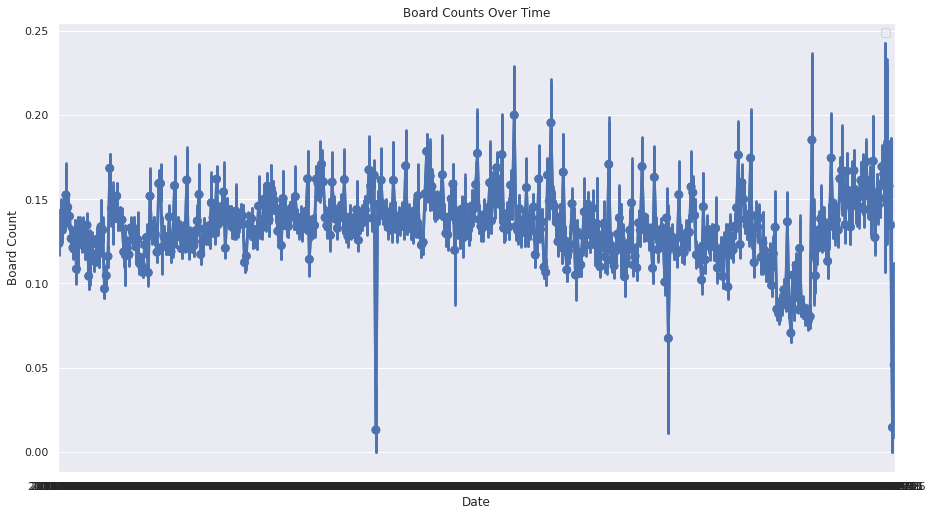

In [10]:
sns.set_theme(style="darkgrid")
plt.title('Board Counts Over Time')
sns.pointplot(x = 'date', y = 'board_count', label = 'Direction 1', data = carta)
sns.pointplot(x = 'date', y = 'board_count', label = 'Direction 0', data = carta)
plt.xlabel("Date")
plt.ylabel("Board Count")
plt.legend()

## Direction 1

No handles with labels found to put in legend.


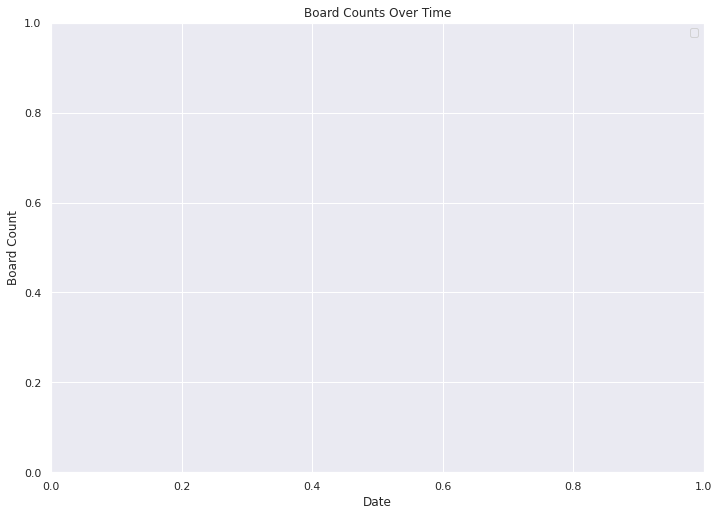

In [91]:
sns.set_theme(style="darkgrid")
plt.title('Board Counts Over Time')
sns.lineplot(x = 'date', y = 'board_count', label = 'Direction 1', data = carta[(carta['route_id'] == '4') & (carta['direction_id'] == '1')])
sns.lineplot(x = 'date', y = 'board_count', label = 'Direction 0', data = carta[(carta['route_id'] == '4') & (carta['direction_id'] == '0')])
plt.xlabel("Date")
plt.ylabel("Board Count")
plt.legend()

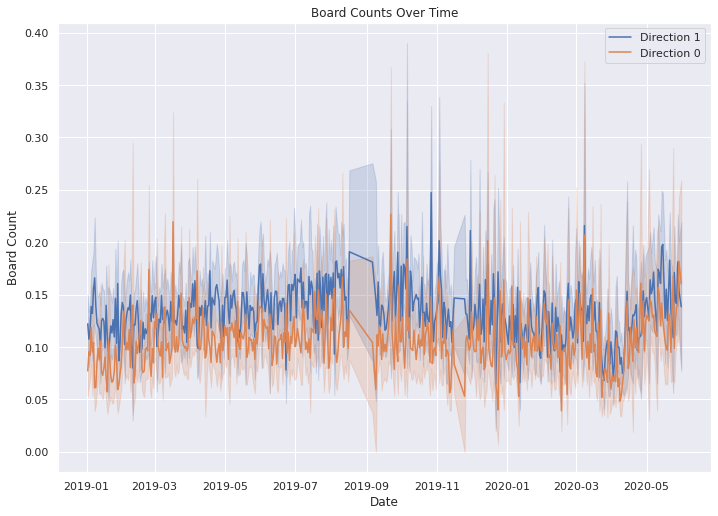

In [88]:
sns.set_theme(style="darkgrid")
plt.title('Board Counts Over Time')
sns.lineplot(x = 'date', y = 'board_count', label = 'Direction 1', data = carta[(carta['route_id'] == '9') & (carta['direction_id'] == '1')])
sns.lineplot(x = 'date', y = 'board_count', label = 'Direction 0', data = carta[(carta['route_id'] == '9') & (carta['direction_id'] == '0')])
plt.xlabel("Date")
plt.ylabel("Board Count")
plt.legend()

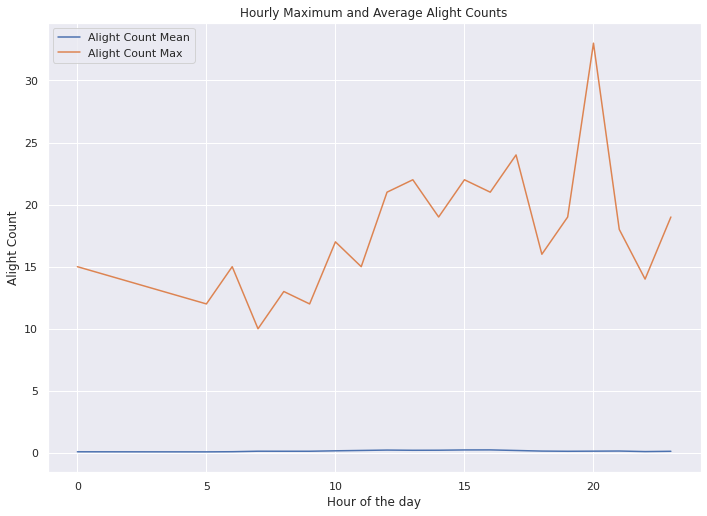

In [68]:
sns.set_theme(style="darkgrid")
plt.title('Hourly Maximum and Average Alight Counts')
sns.lineplot(x = 'Hour', y = 'alight_count_mean', label = 'Alight Count Mean', data = carta_r4_d1_descrip)
sns.lineplot(x = 'Hour', y = 'alight_count_max', label = 'Alight Count Max', data = carta_r4_d1_descrip)
plt.xlabel("Hour of the day")
plt.ylabel("Alight Count")
plt.legend()

## Direction 0

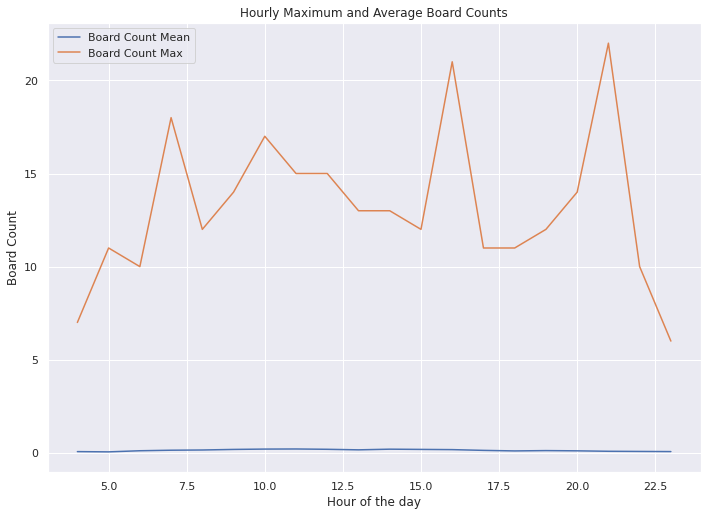

In [76]:
sns.set_theme(style="darkgrid")
plt.title('Hourly Maximum and Average Board Counts')
sns.lineplot(x = 'Hour', y = 'board_count_mean', label = 'Board Count Mean', data = carta_r4_d0_descrip)
sns.lineplot(x = 'Hour', y = 'board_count_max', label = 'Board Count Max', data = carta_r4_d0_descrip)
plt.xlabel("Hour of the day")
plt.ylabel("Board Count")
plt.legend()

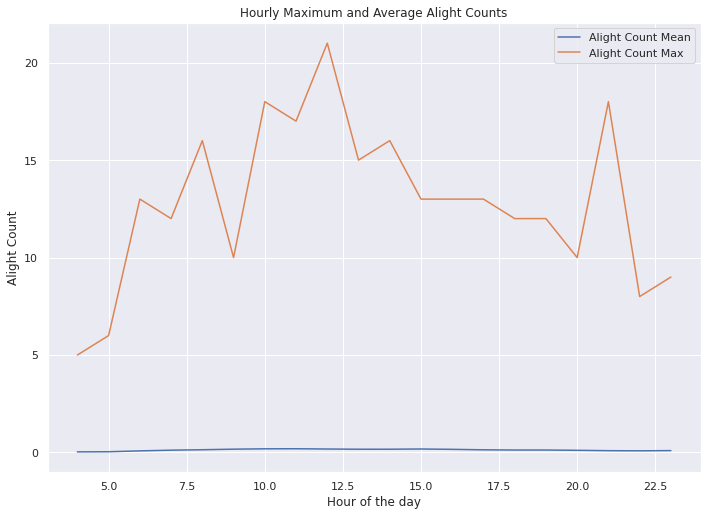

In [77]:
sns.set_theme(style="darkgrid")
plt.title('Hourly Maximum and Average Alight Counts')
sns.lineplot(x = 'Hour', y = 'alight_count_mean', label = 'Alight Count Mean', data = carta_r4_d0_descrip)
sns.lineplot(x = 'Hour', y = 'alight_count_max', label = 'Alight Count Max', data = carta_r4_d0_descrip)
plt.xlabel("Hour of the day")
plt.ylabel("Alight Count")
plt.legend()

## Trip data over time

In [78]:
carta_r4_d1_trip = carta[(carta['year'] == 2020) & (carta['route_id'] == '4') & (carta['direction_id'] == '1')]
carta_r4_d1_trip = carta_r4_d1_trip[['trip_id','actual_arrival_datetime', 'board_count', 'alight_count']]
carta_r4_d1_trip.head()

,trip_id,actual_arrival_datetime,board_count,alight_count
7415888,139718,2020-01-02 05:31:00,1,0
7415924,139718,2020-01-02 05:33:00,0,0
7415935,139718,2020-01-02 05:34:00,0,0
7415943,139718,2020-01-02 05:34:00,0,0
7415981,139718,2020-01-02 05:36:00,0,0


In [79]:
carta_r4_d1_trip.actual_arrival_datetime = pd.to_datetime(carta_r4_d1_trip['actual_arrival_datetime'], format = "%Y-%m-%d %H:%M:%S")
carta_r4_d1_trip['Hour'] = carta_r4_d1_trip.actual_arrival_datetime.dt.hour
carta_r4_d1_trip.head()

,trip_id,actual_arrival_datetime,board_count,alight_count,Hour
7415888,139718,2020-01-02 05:31:00,1,0,5
7415924,139718,2020-01-02 05:33:00,0,0,5
7415935,139718,2020-01-02 05:34:00,0,0,5
7415943,139718,2020-01-02 05:34:00,0,0,5
7415981,139718,2020-01-02 05:36:00,0,0,5


In [80]:
carta_r4_d1_trip['trip_id'].unique()

array(['139718', '139706', '139701', '139709', '139717', '139703',
       '139714', '139699', '139700', '139705', '139731', '139723',
       '139747', '139722', '139732', '139724', '139756', '139748',
       '139738', '139753', '139735', '139725', '139751', '139749',
       '139754', '139736', '139733', '139726', '139759', '139752',
       '139734', '139750', '139755', '139757', '139758', '139715',
       '139707', '139708', '139716', '139710', '139712', '139713',
       '139702', '139719', '139720', '139743', '139739', '139727',
       '139744', '139740', '139728', '139737', '139745', '139741',
       '139729', '139746', '139742', '139730', '139801', '139802',
       '139811', '139829', '139813', '139812', '139814', '139827',
       '139815', '139831', '139816', '139817', '139818', '139828',
       '139819', '139830', '139820', '139841', '139821', '139832',
       '139822', '139834', '139823', '139824', '139825', '139826',
       '139803', '139836', '139833', '139835', '139804', '1398

In [110]:
carta_r4_d1_trips = carta_r4_d1_trip[carta_r4_d1_trip['trip_id'].isin(['139718'])] # , '139706', '139701', '139709', '139717', '139703'
carta_r4_d1_trips.head()

,trip_id,actual_arrival_datetime,board_count,alight_count,Hour
7415888,139718,2020-01-02 05:31:00,1,0,5
7415924,139718,2020-01-02 05:33:00,0,0,5
7415935,139718,2020-01-02 05:34:00,0,0,5
7415943,139718,2020-01-02 05:34:00,0,0,5
7415981,139718,2020-01-02 05:36:00,0,0,5


In [111]:
carta_r4_d1_trips = carta_r4_d1_trips.groupby(['trip_id','actual_arrival_datetime', 'Hour']).agg(['max'])
carta_r4_d1_trips.head()

board_count alight_count
                                             max          max
trip_id actual_arrival_datetime Hour                         
139718  2020-01-02 05:31:00     5              1            0
        2020-01-02 05:33:00     5              0            0
        2020-01-02 05:34:00     5              0            0
        2020-01-02 05:36:00     5              0            0
        2020-01-02 05:37:00     5              0            0

In [112]:
carta_r4_d1_trips.columns = ['board_count_max', 'alight_count_max']
carta_r4_d1_trips.head()

board_count_max  alight_count_max
trip_id actual_arrival_datetime Hour                                   
139718  2020-01-02 05:31:00     5                   1                 0
        2020-01-02 05:33:00     5                   0                 0
        2020-01-02 05:34:00     5                   0                 0
        2020-01-02 05:36:00     5                   0                 0
        2020-01-02 05:37:00     5                   0                 0

In [113]:
carta_r4_d1_trips.reset_index()

,trip_id,actual_arrival_datetime,Hour,board_count_max,alight_count_max
0,139718,2020-01-02 05:31:00,5,1,0
1,139718,2020-01-02 05:33:00,5,0,0
2,139718,2020-01-02 05:34:00,5,0,0
3,139718,2020-01-02 05:36:00,5,0,0
4,139718,2020-01-02 05:37:00,5,0,0
...,...,...,...,...,...
1386,139718,2020-04-09 06:21:00,6,0,0
1387,139718,2020-04-09 06:22:00,6,0,5
1388,139718,2020-04-09 06:23:00,6,0,0
1389,139718,2020-04-09 06:24:00,6,0,0


In [114]:
carta_r4_d1_trips.columns

Index(['board_count_max', 'alight_count_max'], dtype='object')

In [96]:
sns.set(rc={'figure.figsize':(13,8.27)})

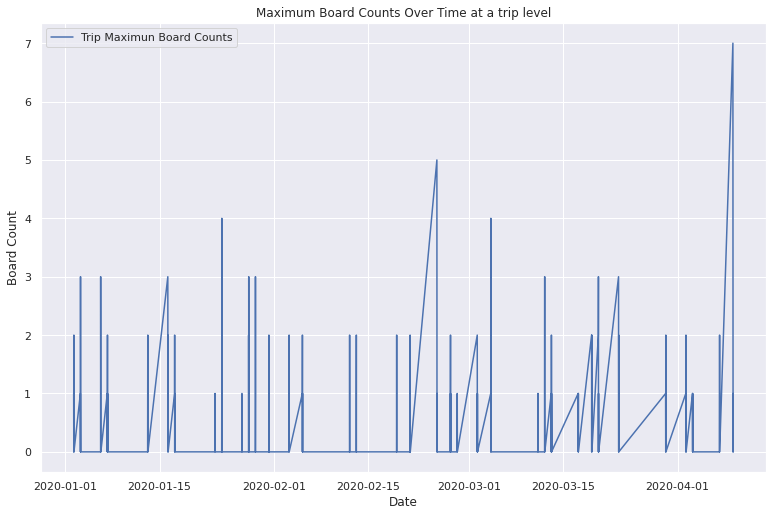

In [117]:
sns.set_theme(style="darkgrid")
plt.title('Maximum Board Counts Over Time at a trip level')
#sns.lineplot(x = 'actual_arrival_datetime', y = 'board_count_mean', label = 'Board Count Mean', data = carta_r4_d1_trips)
sns.lineplot(x = 'actual_arrival_datetime', y = 'board_count_max', label = 'Trip Maximun Board Counts', data = carta_r4_d1_trips)
plt.xlabel("Date")
plt.ylabel("Board Count")
plt.legend()

In [39]:
carta1_month = carta[(carta['year'] == 2020) & (carta['route_id'] == '4') & (carta['direction_id'] == '1')]
carta1_month = carta1_month[['actual_arrival_datetime', 'board_count', 'alight_count']]
carta1_month.head()

,actual_arrival_datetime,board_count,alight_count
7415888,2020-01-02 05:31:00,1,0
7415924,2020-01-02 05:33:00,0,0
7415935,2020-01-02 05:34:00,0,0
7415943,2020-01-02 05:34:00,0,0
7415981,2020-01-02 05:36:00,0,0


In [40]:
carta1_month.actual_arrival_datetime = pd.to_datetime(carta1_month['actual_arrival_datetime'], format = "%Y-%m-%d %H:%M:%S")
carta1_month['Hour'] = carta1_month.actual_arrival_datetime.dt.hour
carta1_month['Month'] = carta1_month.actual_arrival_datetime.dt.month
carta1_month.head()

,actual_arrival_datetime,board_count,alight_count,Hour,Month
7415888,2020-01-02 05:31:00,1,0,5,1
7415924,2020-01-02 05:33:00,0,0,5,1
7415935,2020-01-02 05:34:00,0,0,5,1
7415943,2020-01-02 05:34:00,0,0,5,1
7415981,2020-01-02 05:36:00,0,0,5,1


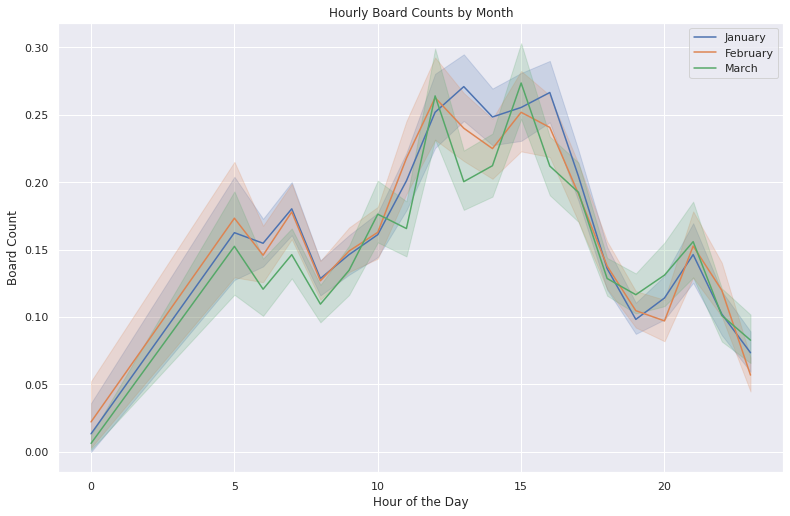

In [55]:
sns.set(rc={'figure.figsize':(13,8.27)})
sns.set_theme(style="darkgrid")
#g = sns.FacetGrid(carta1_month, hue = 'Month')
plt.title('Hourly Board Counts by Month')

sns.lineplot(x = 'Hour', y = 'board_count',  label = 'January', data = carta1_month[carta1_month['Month'] == 1])
sns.lineplot(x = 'Hour', y = 'board_count',  label = 'February', data = carta1_month[carta1_month['Month'] == 2])
sns.lineplot(x = 'Hour', y = 'board_count',  label = 'March', data = carta1_month[carta1_month['Month'] == 3])
plt.xlabel("Hour of the Day")
plt.ylabel("Board Count")
plt.legend()

In [109]:
chart1 = carta1_month.groupby(['Month', 'Hour']).agg(['mean', 'var', 'max'])
chart1 = chart1.reset_index()
chart1.head()

Month Hour board_count               alight_count              
                    mean       var max         mean       var max
0     1    0    0.013387  0.072207   7     0.092369  0.255532   8
1     1    5    0.162550  0.463190  13     0.079681  0.177059   5
2     1    6    0.154704  0.295516  11     0.107358  0.311849  13
3     1    7    0.180246  0.433324   7     0.146280  0.317072   9
4     1    8    0.128531  0.280455   8     0.144798  0.339480   8

In [110]:
chart1.columns = ['Month', 'Hour', 'board_count_mean', 'board_count_variance', 'board_count_max', 'alight_count_mean', 'alight_count_variance', 'alight_count_max']

In [111]:
chart1.head()

,Month,Hour,board_count_mean,board_count_variance,board_count_max,alight_count_mean,alight_count_variance,alight_count_max
0,1,0,0.013387,0.072207,7,0.092369,0.255532,8
1,1,5,0.162550,0.463190,13,0.079681,0.177059,5
2,1,6,0.154704,0.295516,11,0.107358,0.311849,13
3,1,7,0.180246,0.433324,7,0.146280,0.317072,9
4,1,8,0.128531,0.280455,8,0.144798,0.339480,8


In [112]:
chart1.Month = chart1['Month'].astype(str)

In [114]:
chart1[chart1['Month'] == '5']

,Month,Hour,board_count_mean,board_count_variance,board_count_max,alight_count_mean,alight_count_variance,alight_count_max
80,5,5,0.265306,0.485588,3,0.040816,0.080791,2
81,5,6,0.145145,0.270495,4,0.151151,0.467110,7
82,5,7,0.236943,0.535282,9,0.195541,0.506672,8
83,5,8,0.184094,0.408745,7,0.159063,0.410876,10
84,5,9,0.208296,0.529106,7,0.181980,0.554999,12
85,5,10,0.211185,0.590644,10,0.221486,0.720893,12
86,5,11,0.257418,0.933308,15,0.241780,0.825193,12
87,5,12,0.268169,0.788088,9,0.245628,0.860328,12
88,5,13,0.250000,1.017677,13,0.235345,0.961268,14
89,5,14,0.237233,0.754861,14,0.220346,0.720058,13


In [67]:
chart1.to_csv('chart1.csv', index = False)

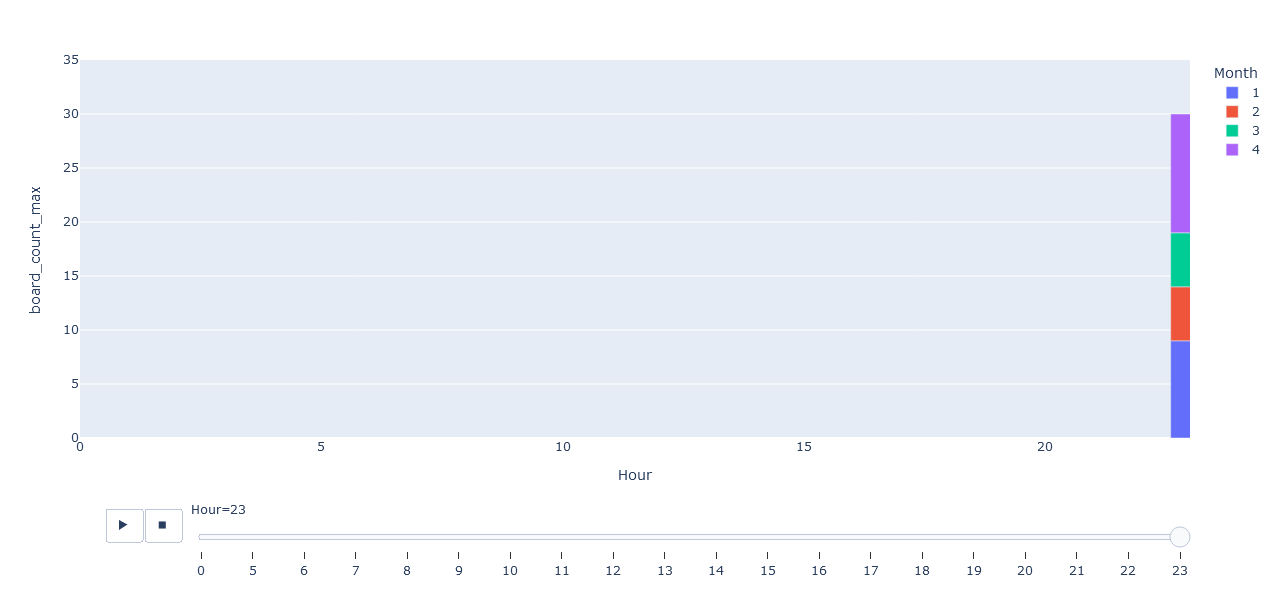

In [131]:
import plotly_express as px
gapminder = px.data.gapminder()
fig=px.bar(chart1, y= "board_count_max",  x="Hour", animation_group = 'Month', color = 'Month',
           animation_frame = 'Hour', height = 600, width = 600, 
           range_y = [0, 35], range_x = [0, 23])
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
fig.show()
#fig.write_html("chart1.html")

In [ ]:
import plotly.express as px
df = px.data.gapminder()
fig = px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country", facet_col="continent",
           log_x=True, size_max=45, range_x=[100,100000], range_y=[25,90])
fig.show()